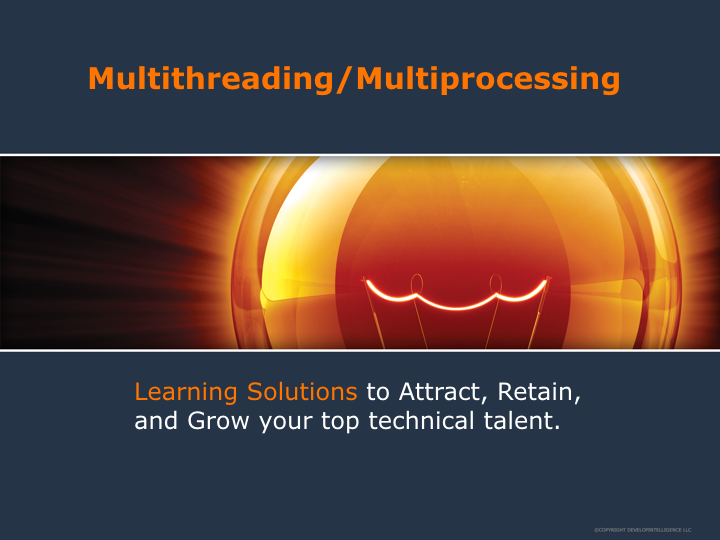

In [1]:
from IPython.display import Image
Image('Multithread.jpg')

### Threading
* typically, concurrency is created so that we can do some task while I/O is happening (e.g., a server can start processing a new request while waiting for data from a previous request to arrive)
* we can create objects that appear to be running independently, but simultaneously
* the job of threading is to enable an application to be responsive
* CPython, the default implementation of Python, has a Global Interpreter Lock (GIL), which prevents your application from doing two things at once, but rather, the CPU time is being rationed across your thread

### Simple threading example

In [2]:
from threading import Thread

class InputReader(Thread):
    """Thread example, extends Thread class"""

    def run(self):
        """
        Whatever is in the run method (or called from
        it) is executed in a separate thread
        """
        self.line_of_text = input('Enter some text: ')

input('Are you ready? When you hit return the thread will start.')
thread = InputReader()
thread.start() # cf. thread.run() for no concurrency

count, result = 1, 1

while thread.is_alive():
    result = count * count
    count += 1

print('calculated squares up to {0} * {0} = {1:,}'.format(count, result))
print('while you typed "{}"'.format(thread.line_of_text))

Are you ready? When you hit return the thread will start.
Enter some text: i
calculated squares up to 1144935 * 1144935 = 1,310,873,864,356
while you typed "i"


In [3]:
# Does not work inside Jupyter
from threading import Thread
import json
from urllib.request import urlopen
import time

cities = ['Boulder', 'Atlanta', 'San Francisco',
          'Reno', 'Honolulu', 'Zurich', 'Dubai',
          'Dublin','Stuttgart', 'Rome']

class TempGetter(Thread):
    def __init__(self, city):
        """Initialize our thread

In the previous example, our class which extended Thread did not
need an __init__ method, because there was no per-thread information
to store. Which means that the __init__ method from the superclass
(Thread) was called automatically. Here, because we need to store
per-thread information (the city), we have to explicitly call the
__init__ method of Thread.
        """
        super().__init__()
        self.city = city

    def run(self):
        url_template = (
            'http://api.openweathermap.org/data/2.5/' 
            'weather?q={}&units=imperial'
                        '&&APPID=10d4440bbaa8581bb8da9bd1fbea5617')
        response = urlopen(url_template.format(self.city))
        data = json.loads(response.read().decode())
        self.temperature = data['main']['temp']

threads = [TempGetter(c) for c in cities]
start = time.time()

for thread in threads:
    thread.start()

for thread in threads:
    thread.join()

for thread in threads:
    print("it is {0.temperature:.0f}°F in {0.city}"
          .format(thread))
print("Got {} temps in {} seconds"
      .format(len(threads), time.time() - start))

it is 75°F in Boulder
it is 41°F in Atlanta
it is 64°F in San Francisco
it is 58°F in Reno
it is 79°F in Honolulu
it is 47°F in Zurich
it is 78°F in Dubai
it is 66°F in Dublin
it is 46°F in Stuttgart
it is 39°F in Rome
Got 10 temps in 0.4693291187286377 seconds


In [4]:
%%bash
python3 getweather.py

it is 63°F in Boulder
it is 41°F in Atlanta
it is 37°F in Germantown
it is 58°F in Reno
it is 79°F in Honolulu
it is 23°F in Zurich
it is 78°F in Dubai
it is 66°F in Dublin
it is 46°F in Stuttgart
it is 50°F in Rome
Got 10 temps in 0.19371700286865234 seconds


## Threading (cont'd)
* the main problem with threads is also their primary advantage–shared memory
 * all threads have access to all the memory
 * what if two threads access the same data?
* synchronization is the solution, but it's tricky
 * bugs due to incorrect synchronization can be very difficult to find due to ordering issues
* one solution is to force communication between threads to occur using a data structure that has built in locking, such as queue.Queue
* disadvantages could be outweighed by the fact that shared memory is FAST, except for the GIL

## Lab: threads
* create a program which uses threads to simulate a database server
* your "database server" should simply be a thread which sleeps for a random interval (check out `time.sleep()` and `random.randint()` if you're not familiar with them)
* your main thread should get input from the user and respond to it (perhaps reversing the input given by the user) while the database thread is busy

## Lab Solution: threads

In [ ]:
# Need to run from Python shell, not in Jupyter and not %%bash
# actually this seems to work in Jupyter now...
from threading import Thread
import random
import time
import sys

running = True

class DatabaseServer(Thread):
    """process imaginary database requests"""
    
    def run(self):
        """
        Whatever is in the run method (or called from
        it, is executed in a separate thread
        """
        while running:
            sec = random.randint(10, 20)
            print('Processing database request for', sec, 'seconds')
            time.sleep(sec)
            print('Finished processing database request')
            sys.stdout.flush()
        print('mp has requested the database server stop running.')

thread = DatabaseServer()
thread.start()

while True:
    text = input('Enter some text: ')
    if text == 'qqq':
        running = False
        while thread.is_alive():
            pass
        break
    print(text[::-1], 'deretne uoY ')

Processing database request for 19 seconds
Enter some text: jnok
konj deretne uoY 
Enter some text: kk
kk deretne uoY 
Enter some text: km
mk deretne uoY 
Finished processing database request
Processing database request for 13 seconds
Enter some text: km'
'mk deretne uoY 
Enter some text: km
mk deretne uoY 
Enter some text: klk
klk deretne uoY 
Enter some text: klk
klk deretne uoY 
Enter some text: lkl
lkl deretne uoY 
Enter some text: lkl
lkl deretne uoY 
Enter some text: lklk
klkl deretne uoY 
Enter some text: lklk
klkl deretne uoY 
Finished processing database request
Processing database request for 19 seconds
Enter some text: k
k deretne uoY 
Enter some text: k]
]k deretne uoY 
Enter some text: jll
llj deretne uoY 
Enter some text: lmmkm
mkmml deretne uoY 
Enter some text: kmkm
mkmk deretne uoY 
Finished processing database request
Enter some text: kmjkm
Processing database request for 14 seconds
mkjmk deretne uoY 
Finished processing database request
Processing database request fo

# Multiprocessing
* the Python multiprocessing library is designed for cases where CPU-bound jobs needs to happen in parallel and multiple cores are available
* advantages
 * separate memory space for each process
 * code is usually straightforward compared to threads
 * avoids GIL limitation
 * eliminates synchronization (assuming no shared memory)

## A Simple Multiprocessing Example

In [12]:
from multiprocessing import Process, cpu_count
import time
import os

class MuchCPU(Process):
    def run(self):
        print(os.getpid())
        for i in range(200000000):
            pass

if __name__ == '__main__':
    print('Running...')
    procs = [MuchCPU() for f in range(cpu_count())]
    t = time.time()
    for p in procs:
        p.start()
    
    for p in procs:
        p.join()
    
    print('work took {} seconds'.format(time.time() - t))

Running...
98682
98683
98684
98685
work took 21.735472917556763 seconds


## Multiprocessing (cont'd)
* no reason for more processes than there are processors
 * only `cpu_count()` procs can run simultaneously
 * each proc consumes resources with a full copy of Python interpreter
 * interproc communication is expensive
 * creating procs takes a nonzero amount of time
* so we create at most `cpu_count()` processes when the program starts and have them execute tasks as needed
* easy to implement a basic series of communicating processes to do this, but it can be tricky to debug, test, and get correct–we don't have to do all this work because the Python developers have already done it for us–multiprocessing pools


## Multiprocessing Pools
* pools abstract away the overhead of figuring out what code is running in main process and what code is running in subprocess
* abstraction restricts the number of places that code in different processes interact with each other, making it easier to keep track of
* pools also hide the passing of data between processes
 * using a pool looks much like a function call–you pass data into a function, it's executed in another process or processes, and when the work is complete, a value is returned
 * under the hood, a lot of work is being done to support this–objects in one process are being pickled (serialized) and passed into a pipe, then another process retrieves data from the pipe and unpickles it. Work is done in the subprocess and a result is produced. The result is pickled and passed into a pipe. Eventually, the original process unpickles it and returns it.

## Multiprocessing Pool Example

In [9]:
import random
import math
from multiprocessing.pool import Pool

def prime_factor(value):
    factors = []
    for divisor in range(2, value-1):
        quotient, remainder = divmod(value, divisor)
        if not remainder:
            factors.extend(prime_factor(divisor))
            factors.extend(prime_factor(quotient))
            break
    else:
        factors = [value]
    return factors

if __name__ == '__main__':
    pool = Pool()

    to_factor = [
        random.randint(100000, 50000000) for i in range(20)
    ]
    results = pool.map(prime_factor, to_factor)
    for value, factors in zip(to_factor, results):
        print("The factors of {} are {}".format(value, factors))

The factors of 25413054 are [2, 3, 311, 13619]
The factors of 2772708 are [2, 2, 3, 19, 12161]
The factors of 30947298 are [2, 3, 5157883]
The factors of 37490844 are [2, 2, 3, 61, 51217]
The factors of 28832121 are [3, 3, 3203569]
The factors of 43520570 are [2, 5, 379, 11483]
The factors of 34549427 are [11, 23, 136559]
The factors of 26669108 are [2, 2, 107, 62311]
The factors of 42910320 are [2, 2, 2, 2, 3, 5, 178793]
The factors of 15677827 are [11, 787, 1811]
The factors of 7712455 are [5, 223, 6917]
The factors of 49323510 are [2, 3, 3, 5, 548039]
The factors of 15325368 are [2, 2, 2, 3, 59, 79, 137]
The factors of 31566741 are [3, 23, 79, 5791]
The factors of 24694619 are [24694619]
The factors of 31095925 are [5, 5, 7, 177691]
The factors of 46738906 are [2, 181, 129113]
The factors of 18388076 are [2, 2, 7, 127, 5171]
The factors of 14402729 are [11, 1309339]
The factors of 10265092 are [2, 2, 19, 31, 4357]


In [7]:
marx_bros = ['Groucho', 'Harpo', 'Chico', 'Zeppo']
stooges = ('Moe', 'Larry', 'Curly')
bradygirls = {'Marcia': 18, 'Jan': 13, 'Cindy': 10}
for bro, stooge, brady in zip(marx_bros, stooges, bradygirls):
    print(bro, '=>', stooge, '=>', brady)

Groucho => Moe => Cindy
Harpo => Larry => Marcia
Chico => Curly => Jan


## Lab: Multiprocessing Pool
* write a program to compute 1!…48! using a multiprocessing pool
* won't be much of a parallelism example, but it's easy to code
* use previous example as a template

## Lab Solution: Multiprocessing Pool

In [ ]:
from multiprocessing.pool import Pool
import math

pool = Pool()
results = pool.map(math.factorial, range(1, 49))
for index, result in zip(range(1, 49), results):
    print(index, result)

## Multiprocessing Issues/What Else
* primary drawback: sharing data between processes is expensive since all communication between processes requires serialization (pickling) the data
* what we didn't cover
 * futures: objects that wrap threading or multiprocessing depending on what kind of concurrency we need (I/O vs. CPU)
 * AsyncIO: current state of the art in Python concurrent programming